In [1]:
import pandas as pd
import scipy.stats
import re
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib as mpl #Some more style nonsense
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi']=300 # dots per inch

In [2]:
calculatedProperties = pd.read_csv("FH_complete_mutation_summary.csv")
calculatedProperties.head()

,Unnamed: 0,Residue,AAfrom,AAto,rhapsodyscore,rhapsodyclass,polyphenscore,polyphenclass,Foldx_energy,Rosetta_energy,Mutation,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,0,49,S,A,0.086,neutral,0.00,neutral,0.061363,3.265,S49A,1.663182,0.992308,23.461148,33.7131
1,1,49,S,C,0.535,neutral,0.86,deleterious,0.067352,7.990,S49C,4.028676,0.992308,23.461148,33.7131
2,2,49,S,D,0.052,neutral,0.00,neutral,-0.103203,1.891,S49D,0.893899,0.992308,23.461148,33.7131
3,3,49,S,E,0.049,neutral,0.00,neutral,-0.086741,0.983,S49E,0.448129,0.992308,23.461148,33.7131
4,4,49,S,F,0.529,neutral,0.62,deleterious,0.182080,4.837,S49F,2.509540,0.992308,23.461148,33.7131


In [3]:
calculatedProperties = calculatedProperties.drop(columns = ["Mutation","Unnamed: 0", "rhapsodyclass","rhapsodyscore","polyphenscore","polyphenclass"])
calculatedProperties

,Residue,AAfrom,AAto,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,49,S,A,0.061363,3.265,1.663182,0.992308,23.461148,33.713100
1,49,S,C,0.067352,7.990,4.028676,0.992308,23.461148,33.713100
2,49,S,D,-0.103203,1.891,0.893899,0.992308,23.461148,33.713100
3,49,S,E,-0.086741,0.983,0.448129,0.992308,23.461148,33.713100
4,49,S,F,0.182080,4.837,2.509540,0.992308,23.461148,33.713100
...,...,...,...,...,...,...,...,...,...
8773,510,K,S,0.571362,1.871,1.221181,0.717073,14.891393,15.359364
8774,510,K,T,0.862076,1.330,1.096038,0.717073,14.891393,15.359364
8775,510,K,V,1.125190,-0.576,0.274595,0.717073,14.891393,15.359364
8776,510,K,W,0.686269,-0.158,0.264134,0.717073,14.891393,15.359364


In [4]:
BayesDel = pd.read_csv("./FH_mutations_BayesDel_Cleaned_2.csv")

In [5]:
# need to match column names to that of calculatedProperties
BayesDel.rename(columns={
    'aapos': 'Residue',
    'aaalt': 'AAto',
    'aaref': 'AAfrom'
}, inplace=True)

BayesDel.head()

,#chr,pos(1-based),ref,alt,genename,rs_dbSNP,AAfrom,AAto,Residue,HGVSc_VEP,HGVSp_VEP,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore
0,1,241497828,T,A,FH,.,X,C,511,c.1533A>T,p.Ter511CysextTer3,0.016367,-0.214267,0.53578
1,1,241497828,T,C,FH,.,X,W,511,c.1533A>G,p.Ter511TrpextTer3,0.048540,-0.168052,0.57861
2,1,241497828,T,G,FH,.,X,C,511,c.1533A>C,p.Ter511CysextTer3,0.019965,-0.209098,0.54067
3,1,241497829,C,A,FH,.,X,L,511,c.1532G>T,p.Ter511LeuextTer3,-0.136883,-0.434399,0.30031
4,1,241497829,C,G,FH,rs2147911168,X,S,511,c.1532G>C,p.Ter511SerextTer3,-0.148895,-0.451654,0.28133


In [6]:
# there's only some tables I want to keep
BayesDel = BayesDel[["AAfrom","AAto","Residue","BayesDel_addAF_score","BayesDel_noAF_score","BayesDel_addAF_rankscore"]]

In [7]:
# merging datasets to get ready for binary classification
BayesDel_calc = BayesDel.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])

### Investigating correlation between parameters

In [8]:
parameters = ["Foldx_energy","Rosetta_energy","average_energy","RSA","Mindist_bindingsiteA","Mindist_hinge"]

Previously I was looping over all the parameters I defined above and printing out the correlation statistic and pvalue repeatedly. This looked ugly and unreadable so I consulted ChatGPT on how to reshape it into a matrix which makes for easier reading. I've done that below

In [9]:
from scipy.stats.stats import pearsonr

# Create an empty DataFrame for the correlation matrix
correlation_matrix = pd.DataFrame(index=parameters, columns=parameters, dtype=float)
for parameter in parameters:
    for parameter2 in parameters:
        statistic, pvalue = scipy.stats.pearsonr(BayesDel_calc[parameter],BayesDel_calc[parameter2])
        correlation_matrix.loc[parameter, parameter2] = statistic
        
correlation_matrix

C:\Users\cembi\AppData\Local\Temp\ipykernel_14636\2830629744.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
Foldx_energy,1.000000,0.573624,0.821866,-0.282082,-0.124794,-0.090513
Rosetta_energy,0.573624,1.000000,0.938079,-0.329317,-0.070569,-0.093335
average_energy,0.821866,0.938079,1.000000,-0.348333,-0.101857,-0.103193
RSA,-0.282082,-0.329317,-0.348333,1.000000,0.333040,0.347129
Mindist_bindingsiteA,-0.124794,-0.070569,-0.101857,0.333040,1.000000,-0.074018
Mindist_hinge,-0.090513,-0.093335,-0.103193,0.347129,-0.074018,1.000000


It's good to see that the Foldx and Rosetta energies have a strong positive correlation with respect to the average energy. The one issue I have is that it looks like the Rosetta energy has a stronger correlation than the Foldx energy, even though this is an average. 

Why might this be? I can find out how the two are calculated by going back onto one of the papers in the briefing (they had it). But I naively thought that the average energy would just be add them and divide by two. Odd.

RSA does not strongly correlate with anything here. Because RSA is dependent on water, solvents, etc. that would biologically make sense. It's good to find results which I don't question for once.

But if there is one thing which has even worse correlation it's the hinge distance parameter. This parameter has almost no correlation at all with every parameter besides RSA. I'm looking at this correlation matrix after having plotted the violin and KDE plots for the hinge distance, so this is actually not so surprising.

### Repeating correlation

In [10]:
parameters = ["Foldx_energy","RSA","Mindist_bindingsiteA","Mindist_hinge"]

In [11]:
from scipy.stats.stats import pearsonr

# Create an empty DataFrame for the correlation matrix
correlation_matrix = pd.DataFrame(index=parameters, columns=parameters, dtype=float)
for parameter in parameters:
    for parameter2 in parameters:
        statistic, pvalue = scipy.stats.pearsonr(BayesDel_calc[parameter],BayesDel_calc[parameter2])
        correlation_matrix.loc[parameter, parameter2] = statistic
        
correlation_matrix

C:\Users\cembi\AppData\Local\Temp\ipykernel_14636\2830629744.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


,Foldx_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
Foldx_energy,1.000000,-0.282082,-0.124794,-0.090513
RSA,-0.282082,1.000000,0.333040,0.347129
Mindist_bindingsiteA,-0.124794,0.333040,1.000000,-0.074018
Mindist_hinge,-0.090513,0.347129,-0.074018,1.000000


In [12]:
BayesDel_calc.head()

,AAfrom,AAto,Residue,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,K,N,510,0.201849,0.052165,0.73873,0.376292,0.300,0.338146,0.717073,14.891393,15.359364
1,K,N,510,0.201844,0.052158,0.73871,0.376292,0.300,0.338146,0.717073,14.891393,15.359364
2,K,M,510,0.323103,0.226338,0.84583,0.559204,-0.019,0.270102,0.717073,14.891393,15.359364
3,K,R,510,0.228331,0.090205,0.76389,-0.292345,-0.738,-0.515173,0.717073,14.891393,15.359364
4,K,T,510,0.344870,0.257605,0.86065,0.862076,1.330,1.096038,0.717073,14.891393,15.359364


In [13]:
bs_calc = BayesDel_calc[BayesDel_calc['BayesDel_noAF_score'] <= -0.057]
ds_calc = BayesDel_calc[BayesDel_calc['BayesDel_noAF_score'] >= -0.057]

In [14]:
# converting tables to string to avoid potential errors
bs_calc = bs_calc.astype(str)
ds_calc = ds_calc.astype(str)
#BayesDel_deleterious = BayesDel_deleterious.astype(str)

In [15]:
# add source column to benign and deleterious tables for classification
bs_calc["source"] = "neutral"
ds_calc["source"] = "deleterious"

In [16]:
logreg_data = pd.concat([bs_calc, ds_calc])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

logreg_data

,AAfrom,AAto,Residue,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,source_deleterious,source_neutral
22,L,V,507,0.125399,-0.0576501,0.66673,1.88196,2.48,2.18098,0.213414634,15.11647605,6.032148733,0,1
33,D,E,505,-0.0749932,-0.345499,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
34,D,E,505,-0.0749939,-0.3455,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
40,D,N,505,-0.00212996,-0.240836,0.51039,-0.211858,0.82,0.304071,0.63803681,18.71564022,10.63279724,0,1
41,K,N,504,-0.0242995,-0.272681,0.47907,1.27046,3.16,2.21523,0.712195122,19.79394051,9.103497551,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054,F,I,50,0.206988,0.0595479,0.74357,2.2606,1.613,1.9368,0.538071066,20.36104043,31.8387706,1,0
3055,S,F,49,0.206421,0.0587329,0.74302,0.18208,4.837,2.50954,0.992307692,23.46114822,33.71310025,1,0
3056,S,C,49,0.194834,0.0420892,0.73211,0.0673518,7.99,4.0286759,0.992307692,23.46114822,33.71310025,1,0
3057,S,Y,49,0.211915,0.0666251,0.74823,0.474099,4.829,2.6515495,0.992307692,23.46114822,33.71310025,1,0


In the code below I'm going to pass in my parameters into `logreg_x`. In Benjamin Hall's paper he used the `average_energy` variable. But I found that actually the `FoldX_energy` seems to be a better predictor of pathogencity than the Rosetta thus average energies.

I think for now I'm going to include `FoldX_energy` only. I can't include all three because then I'd be calculating the covariance between two different energies, which is counterintuitive.

In [17]:
## Look at all parameters - can sub the two energies for average
## (cant include all three as they are convoluted and the model then wont converge)
logreg_y = logreg_data[["source_deleterious"]]
logreg_x = logreg_data[["Foldx_energy","Mindist_bindingsiteA","Mindist_hinge","RSA"]]

logreg_x = logreg_x.astype(float)

plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

In [18]:
# Can replace logit with different models - eg OLS for ordinary least squares
log_reg = sm.Logit(logreg_y, logreg_x).fit(method = "newton", skip_hessian = 0)

Optimization terminated successfully.
         Current function value: 3.000273
         Iterations 8


In the code cell below I'm calling a function `log_reg.cov_params()`. This is the covariance matrix of our parameters in the logistic regression model. The diagonal elements of this matrix represent our variances (remember, that's the square of the standard deviation). Whereas the off-diagonal elements represent our covariances.

A common misconception is that unlike correlation values, covariances are not limited to values between -1 and +1. They can take humongous values (like 10^12, which is what I had at the beginning. Because I made a mistake).

In general the larger the covariance value is between our two parameters, the more those two parameters vary

In [19]:
cov_matrix = log_reg.cov_params()
cov_matrix

,Foldx_energy,Mindist_bindingsiteA,Mindist_hinge,RSA
Foldx_energy,0.002610,-0.000096,-0.000029,0.002158
Mindist_bindingsiteA,-0.000096,0.000055,-0.000023,-0.000899
Mindist_hinge,-0.000029,-0.000023,0.000055,-0.000975
RSA,0.002158,-0.000899,-0.000975,0.077620


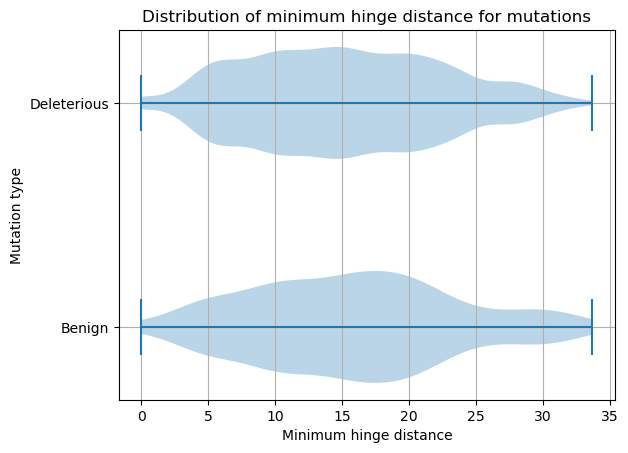

In [20]:
fig, ax = plt.subplots()
# Convert values to float
hinge_distance_benign = bs_calc["Mindist_hinge"].astype(float)
hinge_distance_del = ds_calc["Mindist_hinge"].astype(float)

# Create the violin plot with explicit positions
ax.violinplot([hinge_distance_benign, hinge_distance_del], positions=[1, 2], vert=False)

# Add grid for better visualization
ax.grid()
ax.set_title("Distribution of minimum hinge distance for mutations")

# Set custom labels
ax.set_yticks([1, 2])
ax.set_yticklabels(["Benign", "Deleterious"])

# Add axis labels
ax.set_xlabel("Minimum hinge distance")
ax.set_ylabel("Mutation type")

plt.show()

This is really interesting. It's unlikely I've made a mistake twice. Remember that when I did my ROC analysis using the hinge distance values, our auc values were really poor. Similarly the TPR was also quite bad.

What we can see from this graph is that we really cannot discriminate between the deleterious and benign mutations using the minimum hinge distance as a predictor. Well this was already made clear by the ROC curve but in my opinion this is easier to understand.

I had an idea after this to superimpose the two graphs on eachother so we can easily see where the differences are. Then I remembered that in the Explore gene.ipynb notebook at the end we investigated using KDE plots (kernel density estimates). That one looks more clear so I chose to plot the KDE's instead. 

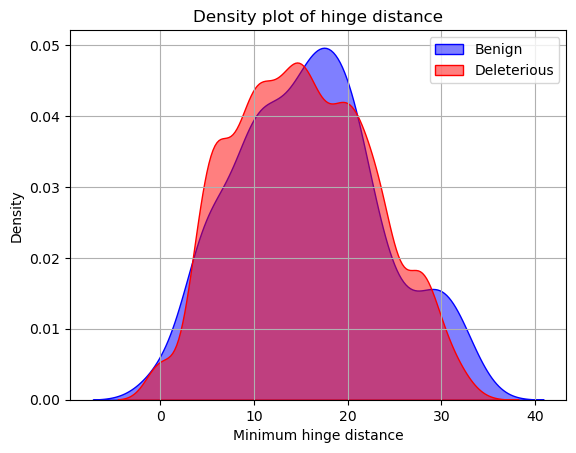

In [21]:
fig, ax = plt.subplots()
# KDE plots for both groups
ax.grid()
sns.kdeplot(hinge_distance_benign, label="Benign", fill=True, color="blue", alpha=0.5)
sns.kdeplot(hinge_distance_del, label="Deleterious", fill=True, color="red", alpha=0.5)

# Labels & Title
ax.set_xlabel("Minimum hinge distance")
ax.set_ylabel("Density")
ax.set_title("Density plot of hinge distance")
ax.legend()

plt.show()

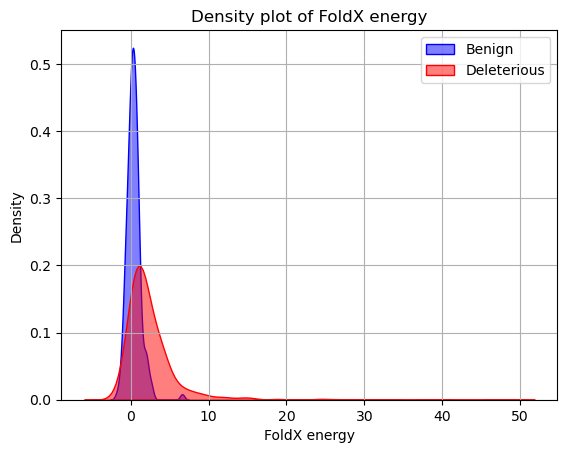

In [22]:
fig, ax = plt.subplots()
# Convert values to float
energy_benign = bs_calc["Foldx_energy"].astype(float)
energy_del = ds_calc["Foldx_energy"].astype(float)

# KDE plots for both groups
sns.kdeplot(energy_benign, label="Benign", fill=True, color="blue", alpha=0.5)
sns.kdeplot(energy_del, label="Deleterious", fill=True, color="red", alpha=0.5)

# Labels & Title
ax.set_xlabel("FoldX energy")
ax.set_ylabel("Density")
ax.set_title("Density plot of FoldX energy")
ax.legend()
ax.grid()
plt.show()

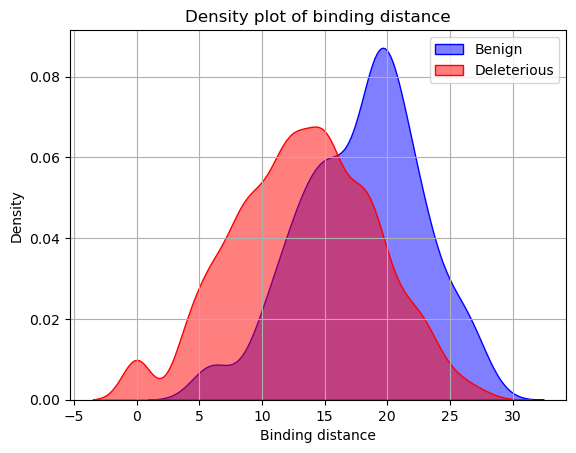

In [23]:
fig, ax = plt.subplots()
# Convert values to float
binding_distance_benign = bs_calc["Mindist_bindingsiteA"].astype(float)
binding_distance_del = ds_calc["Mindist_bindingsiteA"].astype(float)

# KDE plots for both groups
sns.kdeplot(binding_distance_benign, label="Benign", fill=True, color="blue", alpha=0.5)
sns.kdeplot(binding_distance_del, label="Deleterious", fill=True, color="red", alpha=0.5)

# Labels & Title
ax.set_xlabel("Binding distance")
ax.set_ylabel("Density")
ax.set_title("Density plot of binding distance")
ax.legend()
ax.grid()
plt.show()

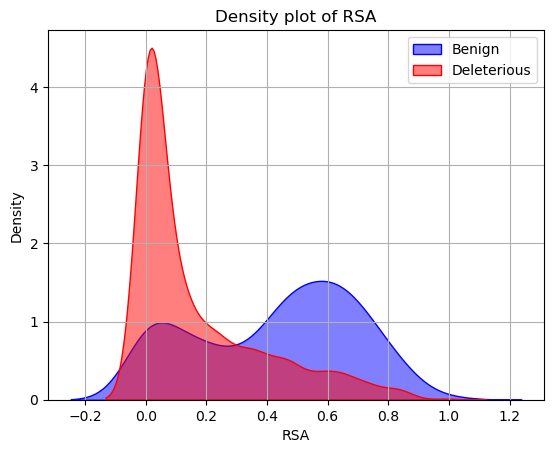

In [24]:
fig, ax = plt.subplots()
# Convert RSA values to float
RSA_benign = bs_calc["RSA"].astype(float)
RSA_del = ds_calc["RSA"].astype(float)

# KDE plots for both groups
sns.kdeplot(RSA_benign, label="Benign", fill=True, color="blue", alpha=0.5)
sns.kdeplot(RSA_del, label="Deleterious", fill=True, color="red", alpha=0.5)

# Labels & Title
ax.set_xlabel("RSA")
ax.set_ylabel("Density")
ax.set_title("Density plot of RSA")
ax.legend()
ax.grid()
plt.show()

This KDE plot of the RSA really drives home our finding that the RSA is the best discriminator between deleterious and benign mutations.

However, this raises a question. We can see from the KDE plots that the hinge distance is by far the worst discriminator. Because there is a lot of overlap between the blue and red graphs. Despite this, what I found was that the RSA and the hinge distance had a very strong negative correlation.
**That's because the correlation matrix actually gives us the correlation between the coefficients and not the actual parameters themselves!**

Another way I can visualise this is by superimposing the violin plots above on eachother.

Below I got help from ChatGPT to improve the presentability of the plot. Unfortunately `ax.violinplot` does not support labelling.

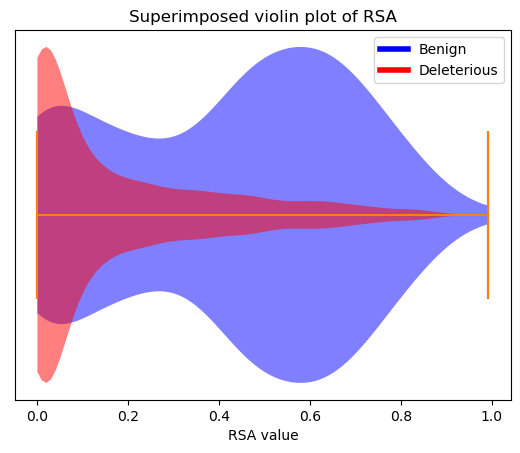

In [25]:
fig, ax = plt.subplots()
# Create violin plots at the same position (so they overlap)
violin1 = ax.violinplot([RSA_benign], positions=[1], vert=False)
violin2 = ax.violinplot([RSA_del], positions=[1], vert=False)

# Customize colors manually (Violin plots don't accept `label`)
for part in violin1['bodies']:
    part.set_facecolor('blue')  # Set benign color
    part.set_alpha(0.5)  # Transparency

for part in violin2['bodies']:
    part.set_facecolor('red')  # Set deleterious color
    part.set_alpha(0.5)

# Add a legend manually
legend_patches = [
    plt.Line2D([0], [0], color='blue', lw=4, label='Benign'),
    plt.Line2D([0], [0], color='red', lw=4, label='Deleterious')
]
ax.legend(handles=legend_patches, loc="upper right")

# Labels & Title
ax.set_xlabel("RSA value")
ax.set_yticks([])  # Remove y-ticks (since both are at position 1)
ax.set_title("Superimposed violin plot of RSA")

plt.show()


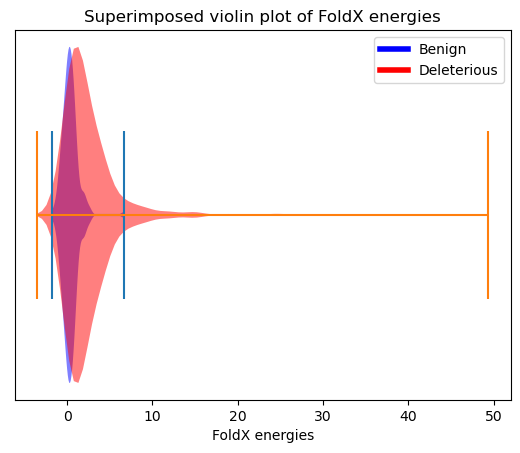

In [26]:
fig, ax = plt.subplots()
## Create violin plots at the same position (so they overlap)
violin1 = ax.violinplot([energy_benign], positions=[1], vert=False)
violin2 = ax.violinplot([energy_del], positions=[1], vert=False)

# Customize colors manually (Violin plots don't accept `label`)
for part in violin1['bodies']:
    part.set_facecolor('blue')  # Set benign color
    part.set_alpha(0.5)  # Transparency

for part in violin2['bodies']:
    part.set_facecolor('red')  # Set deleterious color
    part.set_alpha(0.5)

# Add a legend manually
legend_patches = [
    plt.Line2D([0], [0], color='blue', lw=4, label='Benign'),
    plt.Line2D([0], [0], color='red', lw=4, label='Deleterious')
]
ax.legend(handles=legend_patches, loc="upper right")

# Labels & Title
ax.set_xlabel("FoldX energies")
ax.set_yticks([])  # Remove y-ticks (since both are at position 1)
ax.set_title("Superimposed violin plot of FoldX energies")

plt.show()

#### What could I do next?
Since `hinge_distance` isn't a great predictor, I could drop it from my model. I still don't intuitively understand why `hinge_distance` is not a good predictor. Because the closer we are to the hinge, the more likely it is that our mutation is deleterious. Surely.

In [27]:
logreg_data = pd.concat([bs_calc, ds_calc])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

In [28]:
## Look at all parameters - can sub the two energies for average
## (cant include all three as they are convoluted and the model then wont converge)
logreg_y = logreg_data[["source_deleterious"]]
logreg_x = logreg_data[["Foldx_energy","Mindist_bindingsiteA","RSA"]]

logreg_x = logreg_x.astype(float)

plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

In [29]:
# Can replace logit with different models - eg OLS for ordinary least squares
log_reg = sm.Logit(logreg_y, logreg_x).fit(method = "newton", skip_hessian = 0)

Optimization terminated successfully.
         Current function value: 0.545140
         Iterations 8


In [30]:
cov_matrix_2 = log_reg.cov_params()
cov_matrix_2

,Foldx_energy,Mindist_bindingsiteA,RSA
Foldx_energy,0.002320,-0.000083,0.001070
Mindist_bindingsiteA,-0.000083,0.000040,-0.001131
RSA,0.001070,-0.001131,0.053245


For reference our old covariance matrix was

In [31]:
cov_matrix

,Foldx_energy,Mindist_bindingsiteA,Mindist_hinge,RSA
Foldx_energy,0.002610,-0.000096,-0.000029,0.002158
Mindist_bindingsiteA,-0.000096,0.000055,-0.000023,-0.000899
Mindist_hinge,-0.000029,-0.000023,0.000055,-0.000975
RSA,0.002158,-0.000899,-0.000975,0.077620


It would be interesting to see the differences in the covariance matricies, so,

In [32]:
cov_matrix = cov_matrix.drop(index="Mindist_hinge", columns="Mindist_hinge")
cov_matrix_2 - cov_matrix

,Foldx_energy,Mindist_bindingsiteA,RSA
Foldx_energy,-0.000290,0.000012,-0.001088
Mindist_bindingsiteA,0.000012,-0.000015,-0.000233
RSA,-0.001088,-0.000233,-0.024375


The hinge distance variable had a decently strong correlation with RSA, so I guess it's not really surprising to see that once the hinge distance is removed from our table, the RSA variance has the most drastic change of every covariance in this matrix.